#**Data Preprocessing**


In [1]:
!conda install seaborn -y
!conda install scikit-learn -y


Channels:
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.



In [48]:
# # #step 1: importing library
# # import pandas as pd
# # import numpy as np
# # import seaborn as sns
# # import matplotlib.pyplot as plt
# # import cuml
# # from cuml.linear_model import LinearRegression,ElasticNet,Lasso,Ridge
# # from cuml.model_selection import train_test_split
# # from cuml.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
# # from cuml.ensemble import RandomForestRegressor, GradientBoostingRegressor
# # from cuml.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


import cudf
import cuml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model imports from cuML and scikit-learn
from cuml import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor  # CPU version from scikit-learn
from cuml.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor  # CPU version from scikit-learn
from cuml.linear_model import Ridge
from cuml.model_selection import train_test_split
from cuml.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Verify installed versions of cudf and cuml
print(cudf.__version__)  # Should print the version of cudf
print(cuml.__version__)  # Should print the version of cuml
#step 1: importing library
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,Ridge
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler



23.12.01
23.12.00


In [38]:
import os
import math
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter

plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

%matplotlib inline 

In [3]:
!nvidia-smi 

Thu Mar  6 20:21:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.17              Driver Version: 572.47         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...    On  |   00000000:01:00.0  On |                  N/A |
|  0%   35C    P8             10W /  320W |    1097MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

####Reading Data

In [55]:
#step 2 Reading Data
df1=pd.read_csv('422 datasets/madrid_2001.csv')
df2=pd.read_csv('422 datasets/madrid_2002.csv')
df3=pd.read_csv('422 datasets/madrid_2003.csv')
df4=pd.read_csv('422 datasets/madrid_2004.csv')
df5=pd.read_csv('422 datasets/madrid_2005.csv')
df6=pd.read_csv('422 datasets/madrid_2006.csv')
df7=pd.read_csv('422 datasets/madrid_2007.csv')
df8=pd.read_csv('422 datasets/madrid_2008.csv')
df9=pd.read_csv('422 datasets/madrid_2009.csv')
df10=pd.read_csv('422 datasets/madrid_2010.csv')
df11=pd.read_csv('422 datasets/madrid_2011.csv')
df12=pd.read_csv('422 datasets/madrid_2012.csv')
df13=pd.read_csv('422 datasets/madrid_2013.csv')
df14=pd.read_csv('422 datasets/madrid_2014.csv')
df15=pd.read_csv('422 datasets/madrid_2015.csv')
df16=pd.read_csv('422 datasets/madrid_2016.csv')
df17=pd.read_csv('422 datasets/madrid_2017.csv')
df18=pd.read_csv('422 datasets/madrid_2018.csv')

df=pd.concat([df1, df2, df3,df4,df5,df6,df7,df8,df9, df10, df11,df12,df13,df14,df15,df16, df17,df18], axis=0)

df = df.reset_index(drop=True)
df = df.groupby(['date']).agg('mean')
df_init=df.copy()

In [5]:

#string to date format

df.head()

,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
date,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,3.176667,1.2568,2.560000,4.582,0.239,55.287601,120.004799,2.220,7.8292,30.660417,1.802,22.1004,1.575,10.584444,28079022.44,NaN,NaN,NaN
2001-01-01 02:00:00,7.001111,2.2696,4.711429,5.714,0.383,55.848400,183.621999,2.632,7.0744,41.035909,2.226,24.0064,1.733,19.410000,28079022.44,NaN,NaN,NaN
2001-01-01 03:00:00,9.768889,2.3544,6.628572,10.158,0.401,55.720800,214.429599,4.372,6.8332,56.345218,3.894,25.4832,1.778,29.270000,28079022.44,NaN,NaN,NaN
2001-01-01 04:00:00,9.554444,2.0456,7.222857,14.372,0.365,56.596800,205.904398,6.450,7.1856,47.972083,5.576,23.6180,1.779,30.757778,28079022.44,NaN,NaN,NaN
2001-01-01 05:00:00,7.343333,1.4376,5.522857,11.570,0.260,53.827600,164.040400,5.426,7.9592,36.637083,4.516,20.0304,1.795,24.490000,28079022.44,NaN,NaN,NaN


In [6]:
print('Features:')
for i,j in enumerate(df.columns):
  print(i+1,'->',j)

Features:
1 -> BEN
2 -> CO
3 -> EBE
4 -> MXY
5 -> NMHC
6 -> NO_2
7 -> NOx
8 -> OXY
9 -> O_3
10 -> PM10
11 -> PXY
12 -> SO_2
13 -> TCH
14 -> TOL
15 -> station
16 -> PM25
17 -> NO
18 -> CH4


####First Five Value


In [7]:
df.head()

,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
date,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,3.176667,1.2568,2.560000,4.582,0.239,55.287601,120.004799,2.220,7.8292,30.660417,1.802,22.1004,1.575,10.584444,28079022.44,NaN,NaN,NaN
2001-01-01 02:00:00,7.001111,2.2696,4.711429,5.714,0.383,55.848400,183.621999,2.632,7.0744,41.035909,2.226,24.0064,1.733,19.410000,28079022.44,NaN,NaN,NaN
2001-01-01 03:00:00,9.768889,2.3544,6.628572,10.158,0.401,55.720800,214.429599,4.372,6.8332,56.345218,3.894,25.4832,1.778,29.270000,28079022.44,NaN,NaN,NaN
2001-01-01 04:00:00,9.554444,2.0456,7.222857,14.372,0.365,56.596800,205.904398,6.450,7.1856,47.972083,5.576,23.6180,1.779,30.757778,28079022.44,NaN,NaN,NaN
2001-01-01 05:00:00,7.343333,1.4376,5.522857,11.570,0.260,53.827600,164.040400,5.426,7.9592,36.637083,4.516,20.0304,1.795,24.490000,28079022.44,NaN,NaN,NaN


####Last Five Values

In [8]:
df.tail()

,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
date,,,,,,,,,,,,,,,,,,
2018-04-30 20:00:00,0.283333,0.24,0.150000,NaN,0.063333,25.666667,33.500000,NaN,81.428571,7.307692,NaN,4.2,1.310000,0.533333,28079037.75,4.333333,5.083333,1.246667
2018-04-30 21:00:00,0.350000,0.25,0.216667,NaN,0.063333,31.750000,39.083333,NaN,72.571429,9.153846,NaN,4.4,1.313333,0.866667,28079037.75,4.333333,4.708333,1.250000
2018-04-30 22:00:00,0.316667,0.25,0.200000,NaN,0.063333,30.333333,36.625000,NaN,67.571429,8.076923,NaN,4.5,1.313333,0.716667,28079037.75,4.666667,4.083333,1.250000
2018-04-30 23:00:00,0.366667,0.28,0.200000,NaN,0.066667,39.375000,45.625000,NaN,53.428571,7.076923,NaN,4.4,1.333333,0.683333,28079037.75,3.333333,4.083333,1.263333
2018-05-01 00:00:00,0.383333,0.25,0.200000,NaN,0.060000,29.125000,33.750000,NaN,56.357143,4.461538,NaN,4.5,1.323333,0.850000,28079037.75,2.666667,2.875000,1.263333


####Description Of Dataset

In [9]:
#shape
print('Shape:(row,col)')
print(df.shape)
print('***'*10)
#information of the datas
print('Information:')
print(df.info())
print('***'*10)


Shape:(row,col)
(151896, 18)
******************************
Information:
<class 'pandas.core.frame.DataFrame'>
Index: 151896 entries, 2001-01-01 01:00:00 to 2018-05-01 00:00:00
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   BEN      151867 non-null  float64
 1   CO       151868 non-null  float64
 2   EBE      151867 non-null  float64
 3   MXY      82190 non-null   float64
 4   NMHC     151868 non-null  float64
 5   NO_2     151868 non-null  float64
 6   NOx      92716 non-null   float64
 7   OXY      82190 non-null   float64
 8   O_3      151868 non-null  float64
 9   PM10     151837 non-null  float64
 10  PXY      82185 non-null   float64
 11  SO_2     151868 non-null  float64
 12  TCH      151869 non-null  float64
 13  TOL      151867 non-null  float64
 14  station  151896 non-null  float64
 15  PM25     124629 non-null  float64
 16  NO       64241 non-null   float64
 17  CH4      5087 non-null    float64
dtypes: fl

#Visualizing Data

####Dsecription of the Data

In [10]:
#descriptive statistics (numerical)
print(df.describe().T)

            count          mean        std           min           25%  \
BEN      151867.0  1.194644e+00   1.375780  0.000000e+00  4.533333e-01   
CO       151868.0  4.932875e-01   0.386875  0.000000e+00  2.700000e-01   
EBE      151867.0  1.364781e+00   1.515066  0.000000e+00  5.833333e-01   
MXY       82190.0  4.260760e+00   4.084012  0.000000e+00  1.630000e+00   
NMHC     151868.0  1.889653e-01   0.104801  0.000000e+00  1.236364e-01   
NO_2     151868.0  5.005935e+01  28.430836  0.000000e+00  2.837500e+01   
NOx       92716.0  1.088978e+02  89.223979  0.000000e+00  5.227589e+01   
OXY       82190.0  2.131111e+00   1.781486  0.000000e+00  1.000000e+00   
O_3      151868.0  4.150794e+01  28.814810  0.000000e+00  1.639777e+01   
PM10     151837.0  2.675324e+01  20.913477  0.000000e+00  1.258333e+01   
PXY       82185.0  1.924343e+00   1.670952  0.000000e+00  9.350000e-01   
SO_2     151868.0  9.416328e+00   6.419246  0.000000e+00  5.800000e+00   
TCH      151869.0  1.429207e+00   0.17

###Histogram to understand the distribution

####KDE Plot for better understaning of Distribution

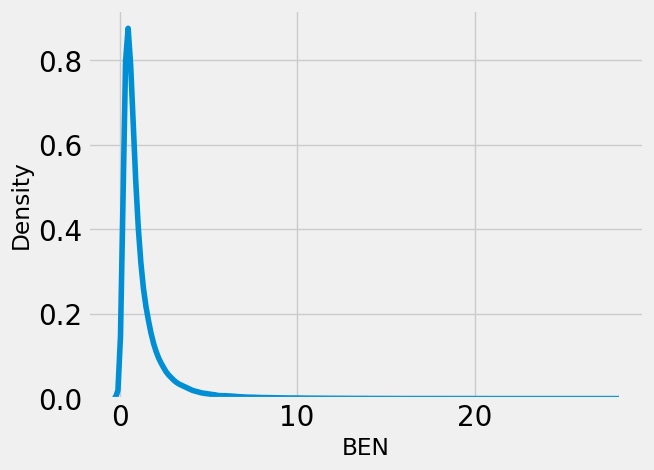

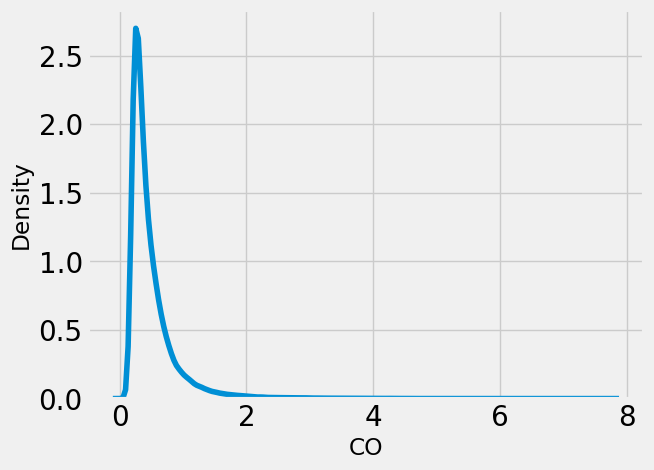

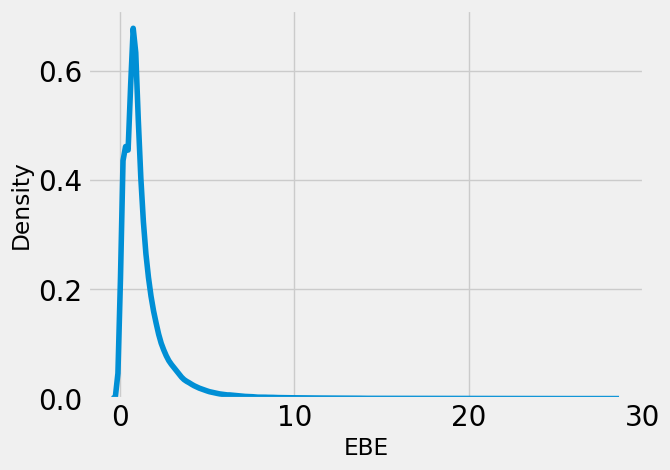

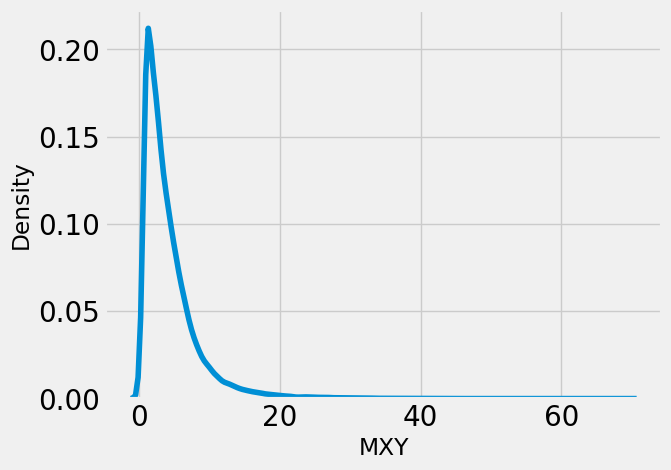

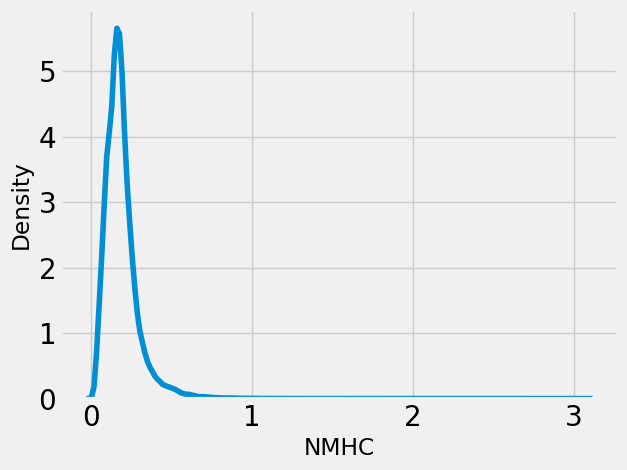

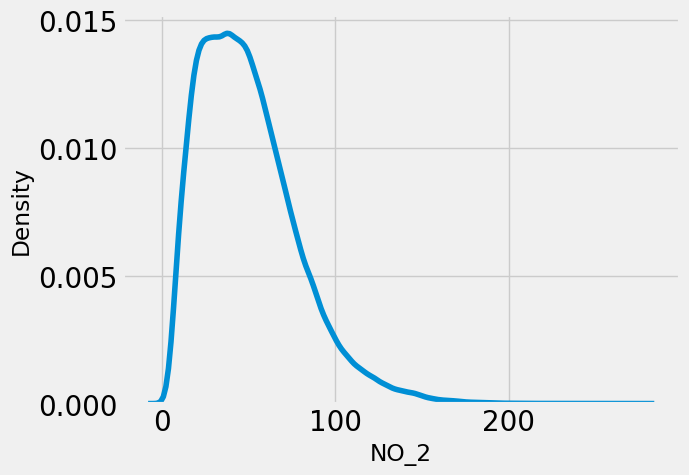

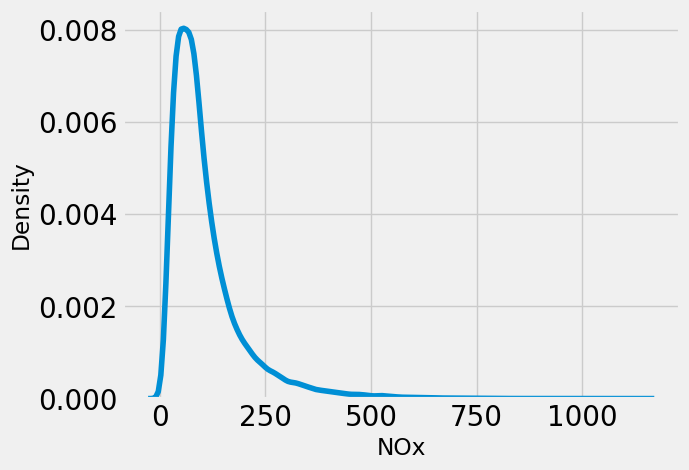

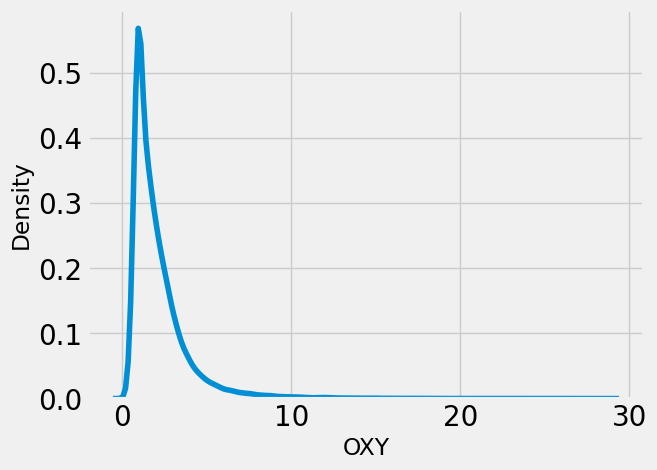

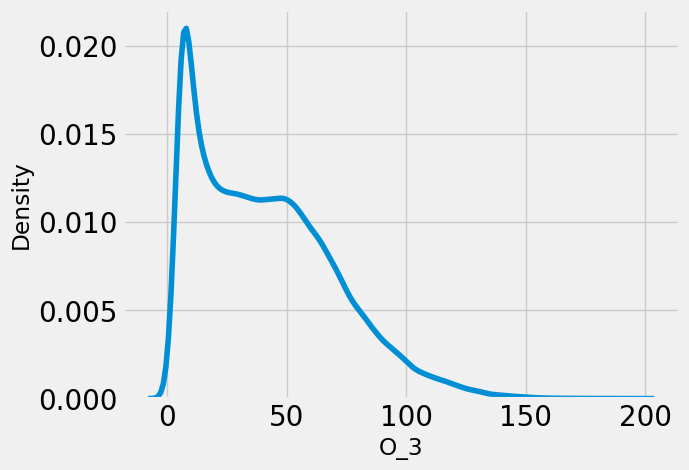

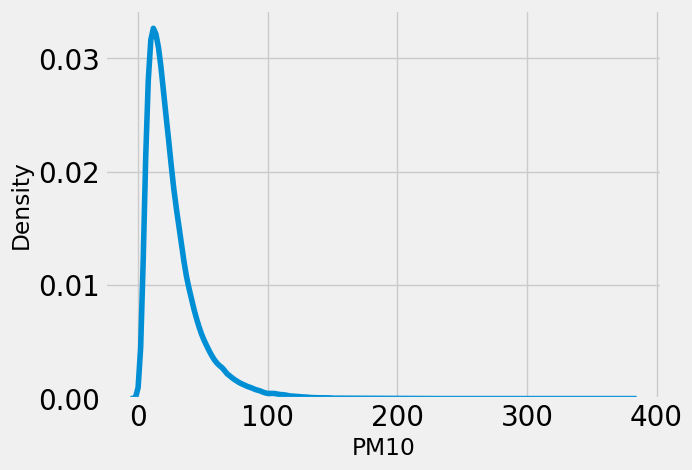

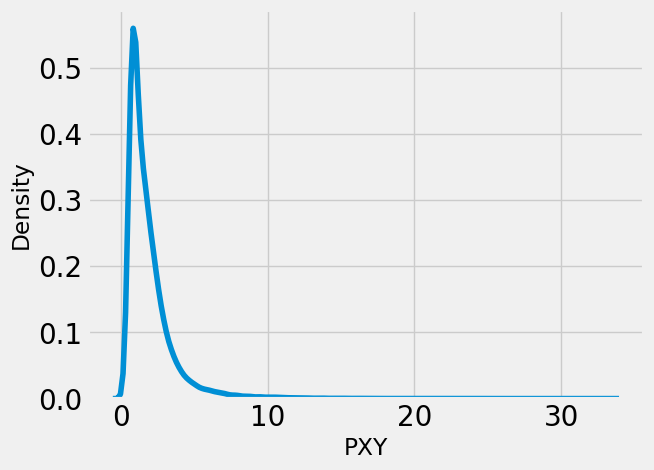

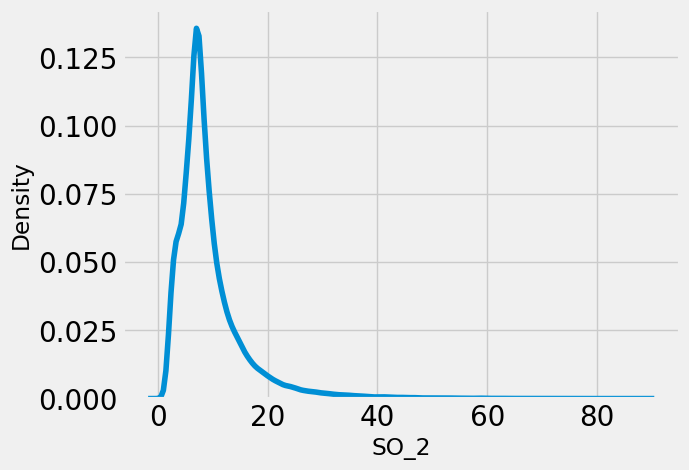

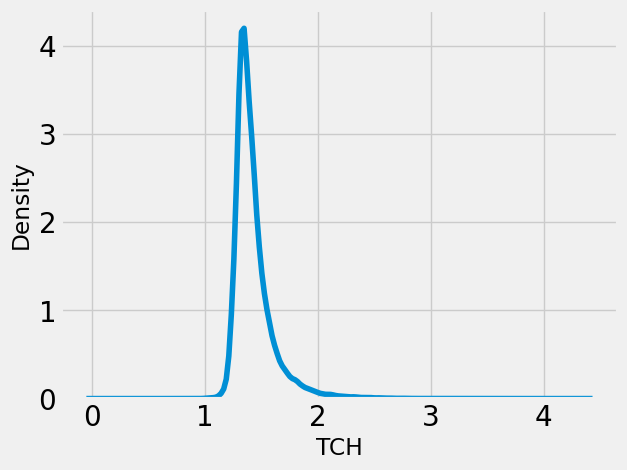

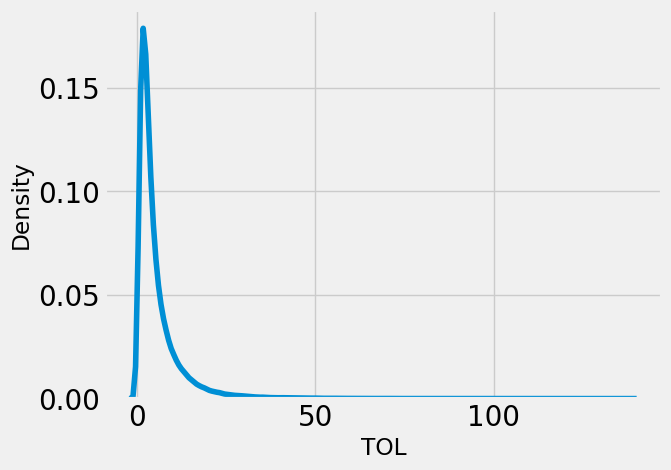

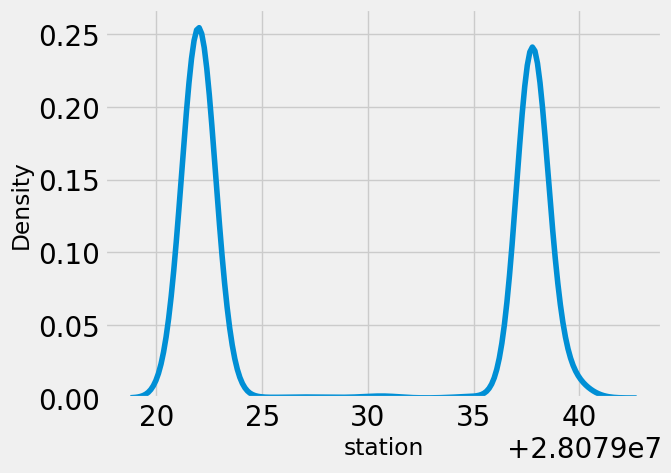

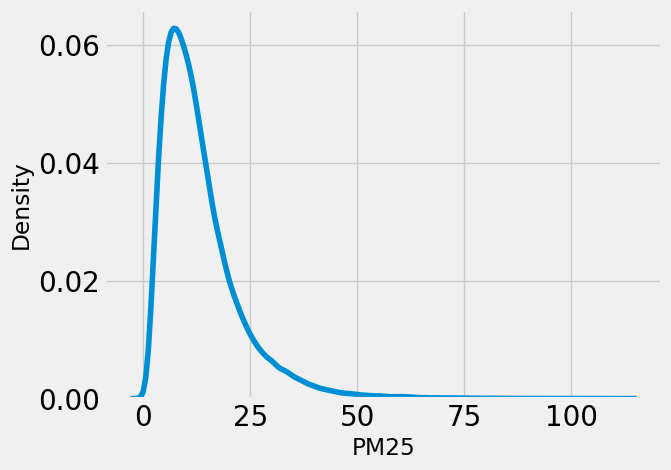

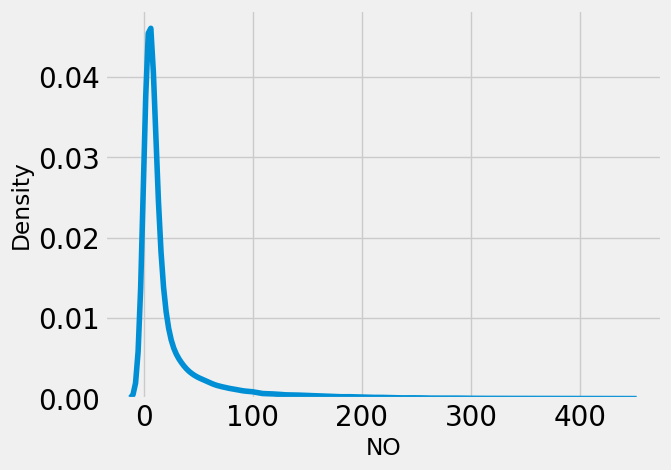

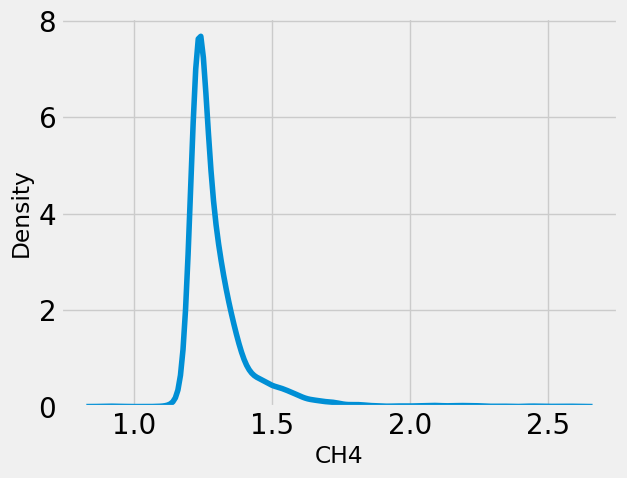

In [21]:
for i in df.select_dtypes(include=['number', 'datetime']).columns:
  sns.kdeplot(data=df, x=i)
  plt.show()

####Scatter plot to understanf the relationship

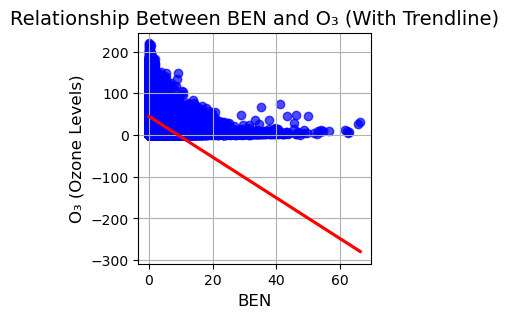

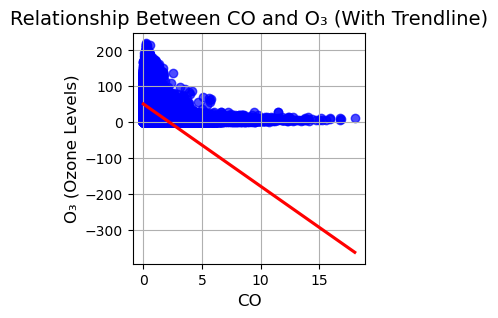

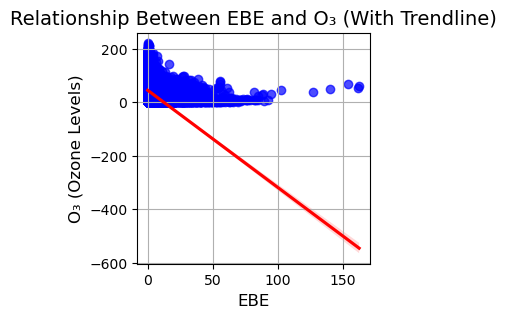

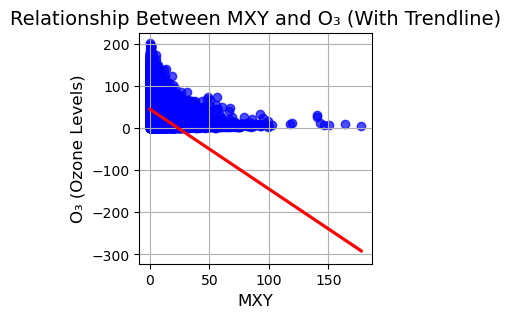

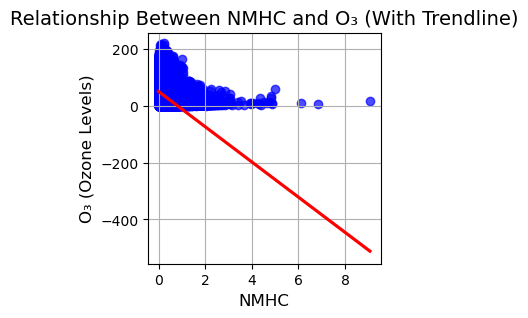

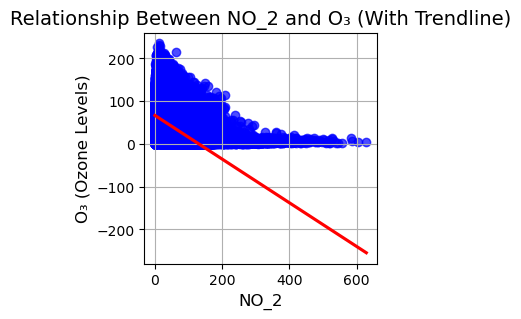

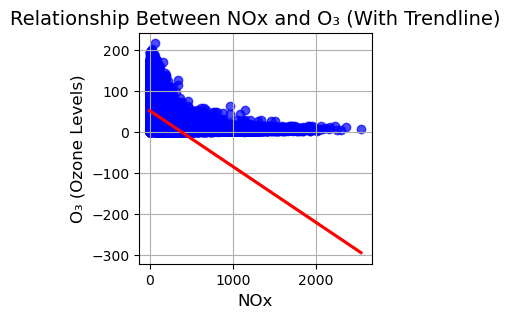

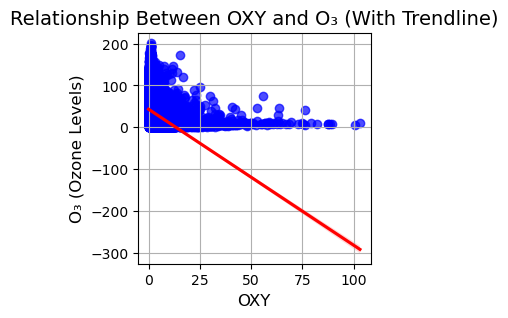

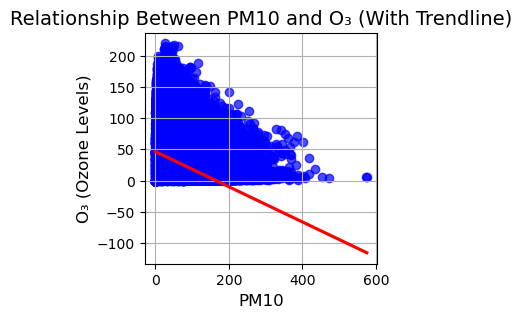

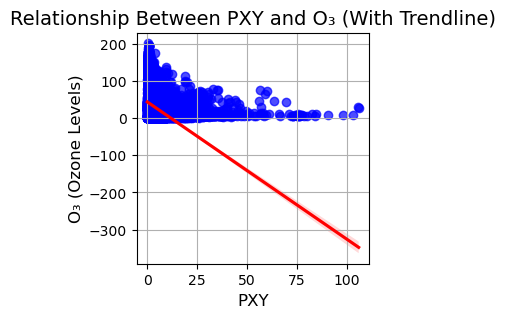

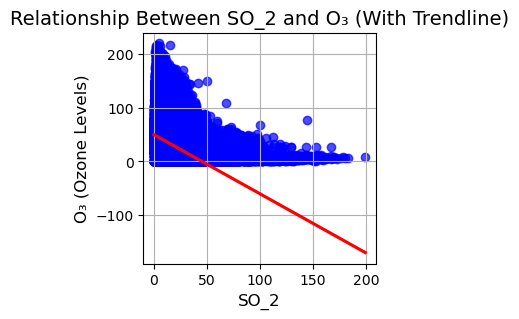

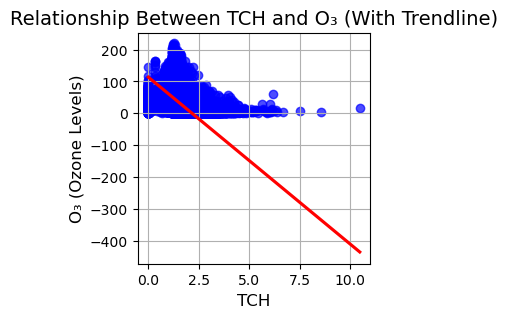

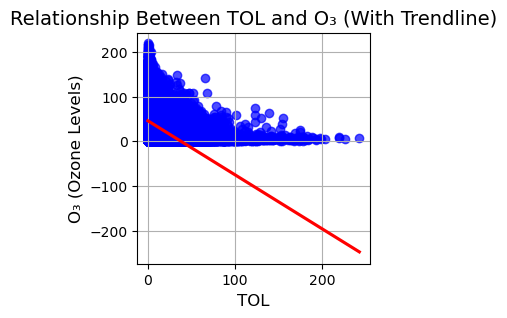

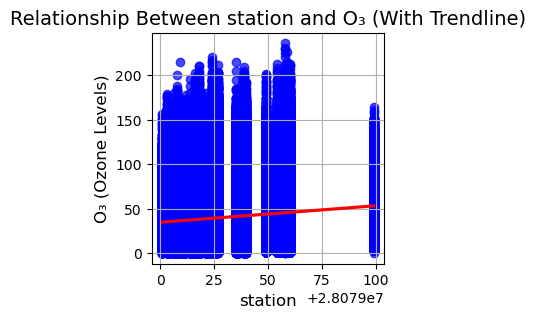

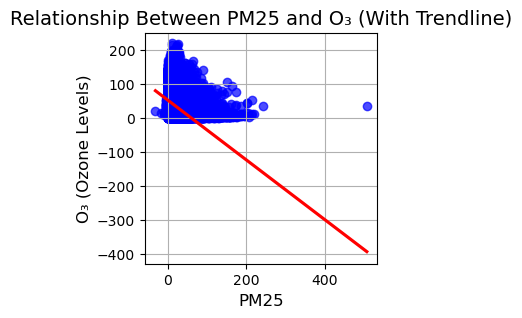

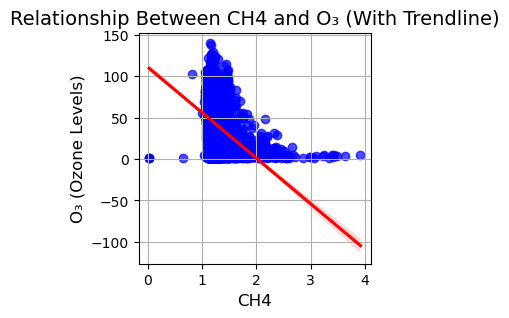

In [12]:
# # #scatter plot understand the relationship
## List of features to analyze


features = ['BEN', 'CO', 'EBE', 'MXY', 'NMHC', 'NO_2', 'NOx', 'OXY',
       'PM10', 'PXY', 'SO_2', 'TCH', 'TOL', 'station','PM25','CH4']

for feature in features:
        plt.figure(figsize=(3, 3))
        sns.regplot(
            data=df,
            x=feature,
            y='O_3',
            scatter_kws={'alpha': 0.7, 'color': 'blue'},
            line_kws={'color': 'red'}
        )
        plt.title(f'Relationship Between {feature} and O₃ (With Trendline)', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('O₃ (Ozone Levels)', fontsize=12)
        plt.grid(True)
        plt.show()


####Correlation with heatmap to intrepret the relation and multicollinarity

<Axes: >

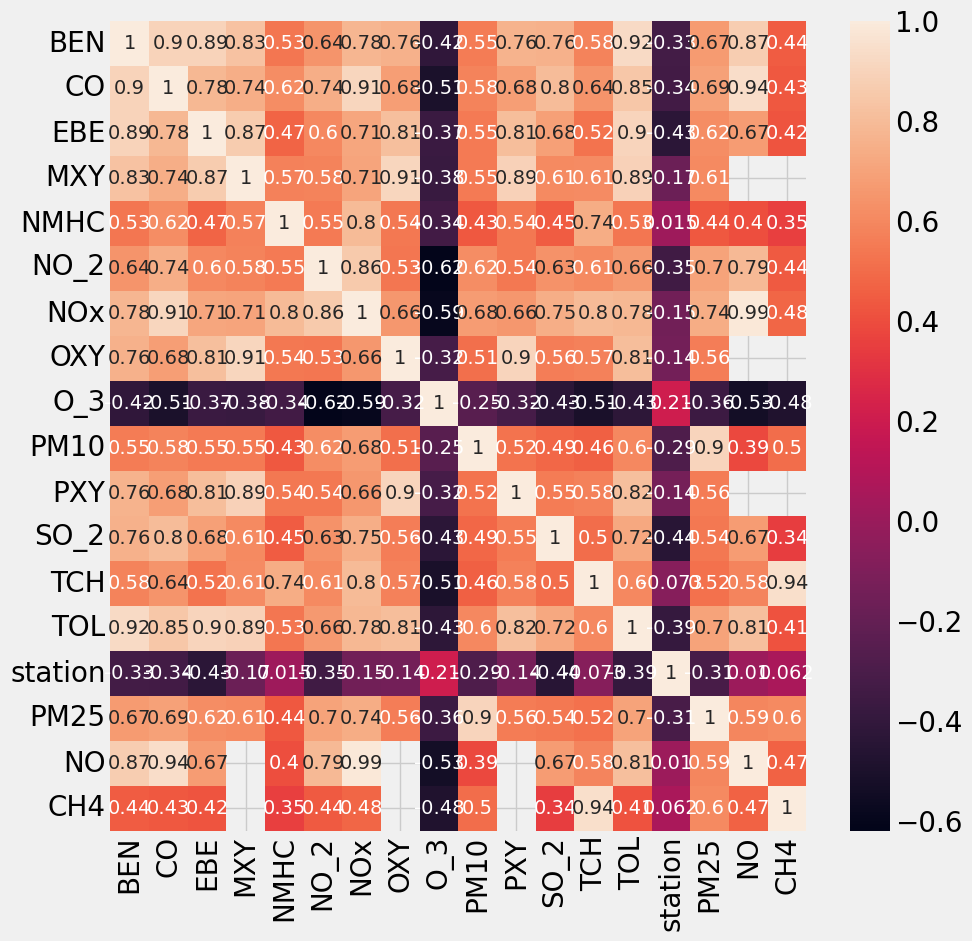

In [28]:
# correlation with heatmap to intrepret the relation and multicollinarity
df.select_dtypes(include='number').corr()
plt.figure(figsize=(10,10))
sns.heatmap(df.select_dtypes(include='number').corr(),annot=True)

###Finding the outliers of the dataset using BoxPlot

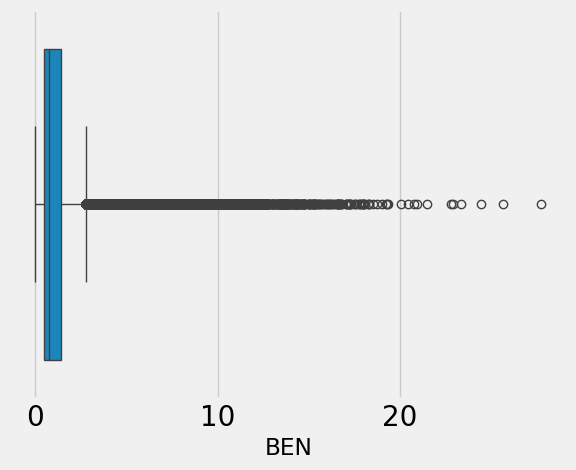

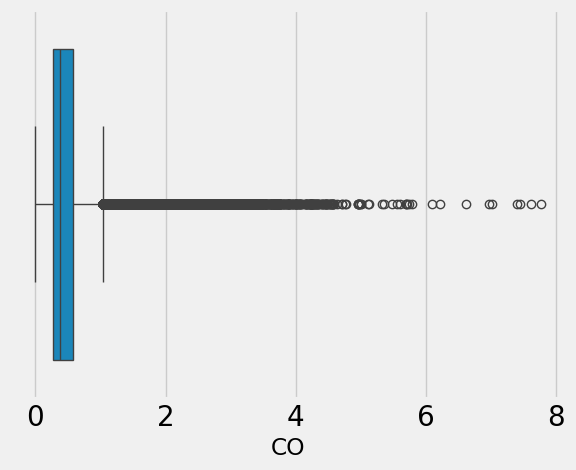

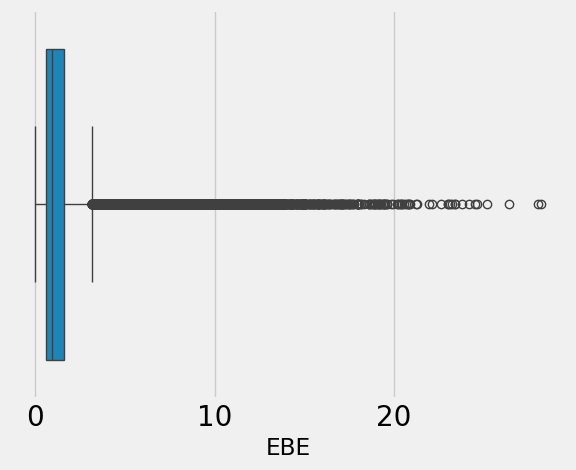

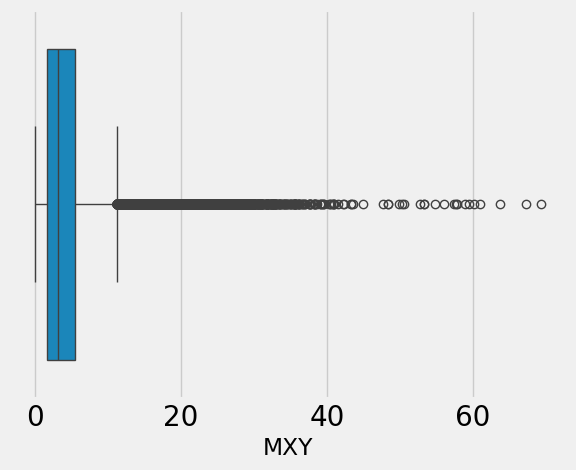

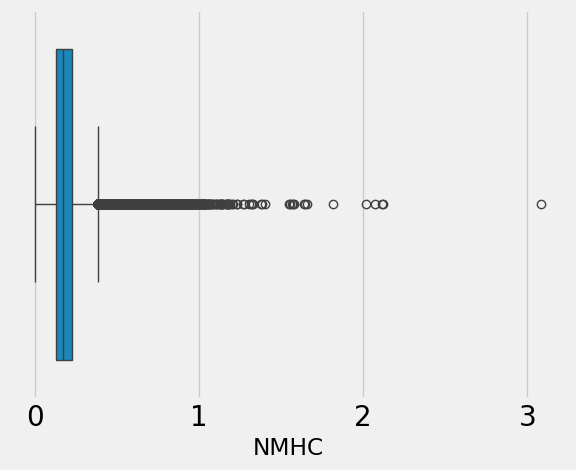

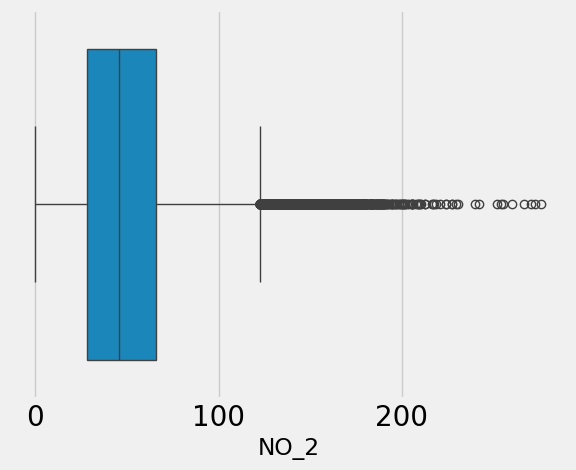

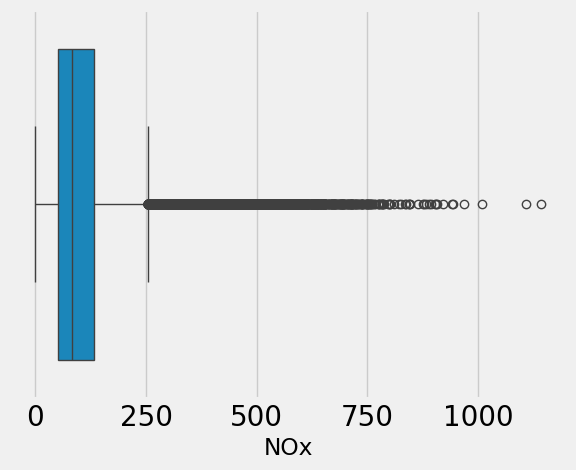

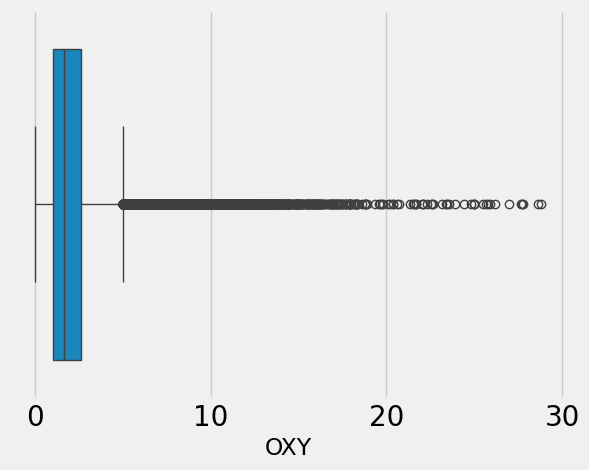

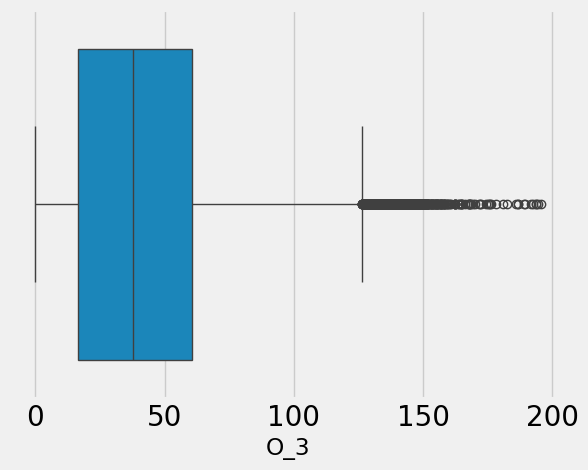

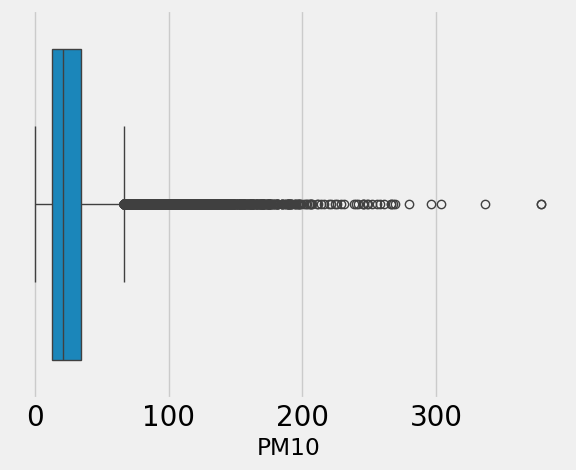

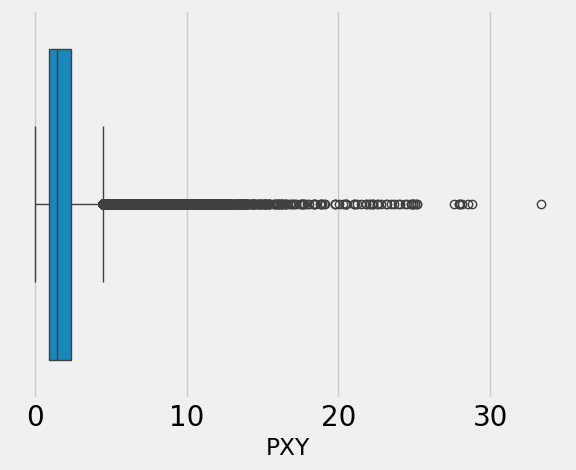

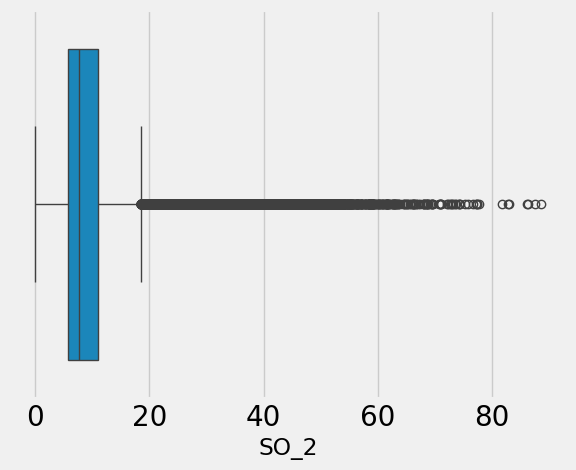

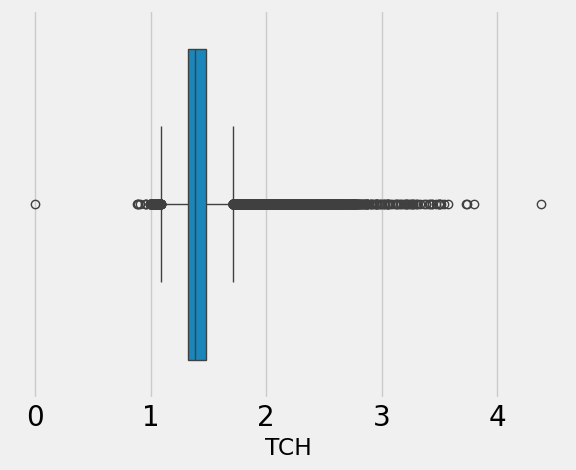

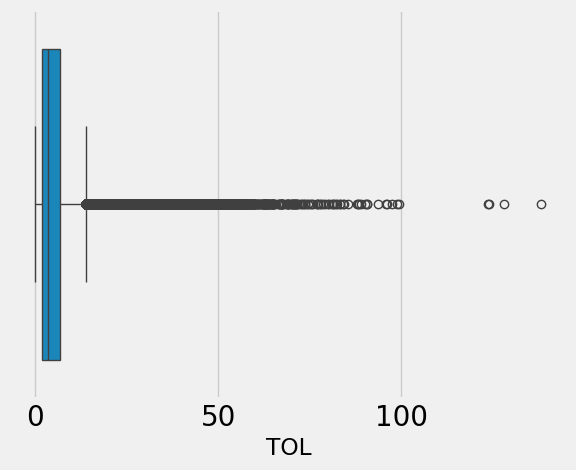

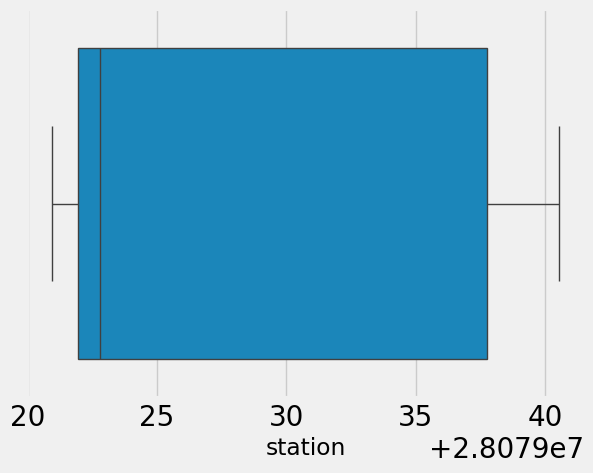

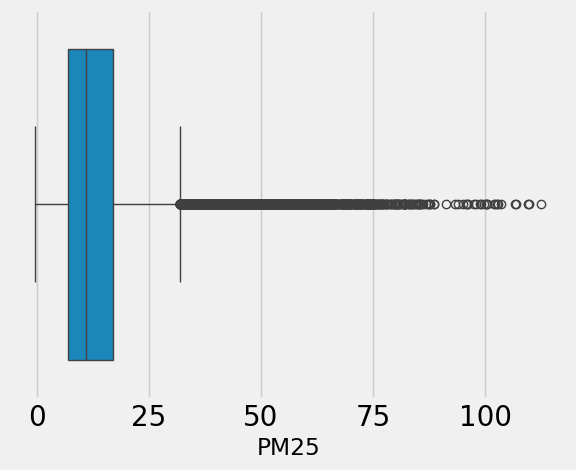

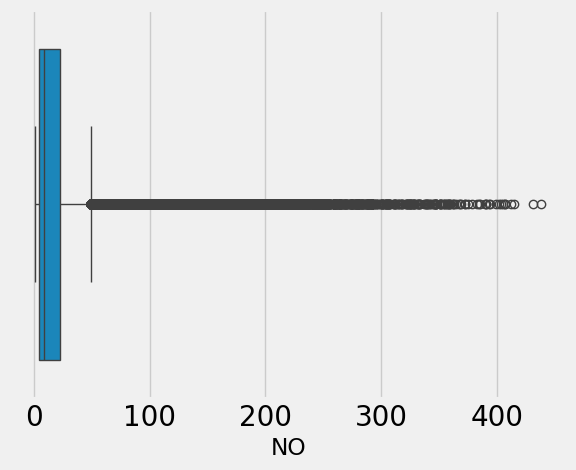

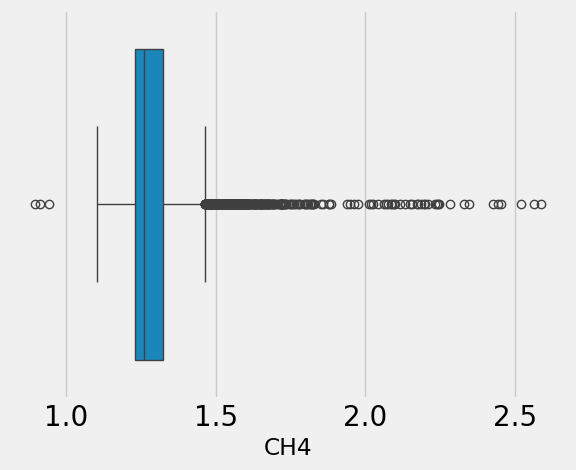

In [29]:
#box plot to understand the outliers
for i in df.select_dtypes(include="number").columns:
  sns.boxplot(data=df,x=i)
  plt.show()

#Data Cleaning

In [22]:
#finding missing value
print('Missing Value:')
print(df.isnull().sum())
print('***'*10)
#finding percantage of missing value
print('Percentage of Missing Value:')
print(df.isnull().sum()/df.shape[0]*100)
print('***'*10)
#finding duplicates
print('Duplicates:')
print(df.duplicated().sum())
print('***'*10)
#idenfying garbage value
print('Garbage Value:')
for i in df.select_dtypes(include='object').columns: #cz garbage are in object type value
   print(df[i].value_counts())
   print('***'*10)
# no garbage value as it would show in the last and show the character and the count also


Missing Value:
BEN            29
CO             28
EBE            29
MXY         69706
NMHC           28
NO_2           28
NOx         59180
OXY         69706
O_3            28
PM10           59
PXY         69711
SO_2           28
TCH            27
TOL            29
station         0
PM25        27267
NO          87655
CH4        146809
dtype: int64
******************************
Percentage of Missing Value:
BEN         0.019092
CO          0.018434
EBE         0.019092
MXY        45.890609
NMHC        0.018434
NO_2        0.018434
NOx        38.960868
OXY        45.890609
O_3         0.018434
PM10        0.038842
PXY        45.893901
SO_2        0.018434
TCH         0.017775
TOL         0.019092
station     0.000000
PM25       17.951098
NO         57.707247
CH4        96.650998
dtype: float64
******************************
Duplicates:
17
******************************
Garbage Value:


###dropping these features since the missing values percentage is greater than 50% and there are no duplicate value and Garbage values in the dataset


In [23]:
df=df.drop(['CH4', 'MXY', 'NO', 'NOx', 'OXY', 'PM25', 'PXY','station'], axis = 1)
df.head()
#[Dropping station as it is irrelevant for our analysis]

,BEN,CO,EBE,NMHC,NO_2,O_3,PM10,SO_2,TCH,TOL
date,,,,,,,,,,
2001-01-01 01:00:00,3.176667,1.2568,2.560000,0.239,55.287601,7.8292,30.660417,22.1004,1.575,10.584444
2001-01-01 02:00:00,7.001111,2.2696,4.711429,0.383,55.848400,7.0744,41.035909,24.0064,1.733,19.410000
2001-01-01 03:00:00,9.768889,2.3544,6.628572,0.401,55.720800,6.8332,56.345218,25.4832,1.778,29.270000
2001-01-01 04:00:00,9.554444,2.0456,7.222857,0.365,56.596800,7.1856,47.972083,23.6180,1.779,30.757778
2001-01-01 05:00:00,7.343333,1.4376,5.522857,0.260,53.827600,7.9592,36.637083,20.0304,1.795,24.490000


###Cleaning datas where target value (O_3) is Null

In [24]:
df= df.dropna(subset=['O_3']) #i deleted all null rows to check the result
# df= df.dropna(subset=['NO_2'])
# df= df.dropna(subset=['PM10'])
# df= df.dropna(subset=['CO'])
# df= df.dropna(subset=['SO_2'])

print('New Shape after dropping null rows of  value:')
df.shape

New Shape after dropping null rows of  value:


(151868, 10)

###Imputing other NULL values using KNNI Imputer


In [25]:
df['CO'].fillna(df['CO'].mean(), inplace = True)
df['NO_2'].fillna(df['NO_2'].mean(), inplace = True)
df['SO_2'].fillna(df['SO_2'].mean(), inplace = True)

df['BEN'].fillna(df['BEN'].mean(), inplace = True)
df['PM10'].fillna(df['PM10'].mean(), inplace = True)


df['SO_2'].fillna(df['SO_2'].mean(), inplace = True)
df['TCH'].fillna(df['TCH'].mean(), inplace = True)


df['TOL'].fillna(df['TOL'].mean(), inplace = True)
df['NMHC'].fillna(df['NMHC'].mean(), inplace = True)
df['EBE'].fillna(df['EBE'].mean(), inplace = True)


In [26]:
print('Result After imputing:\n',df.isnull().sum())
df.shape

Result After imputing:
 BEN     0
CO      0
EBE     0
NMHC    0
NO_2    0
O_3     0
PM10    0
SO_2    0
TCH     0
TOL     0
dtype: int64


(151868, 10)

### Caluculating wisker to treat outliers

In [27]:
#Outlier treatment
def wisker(col):
  q1,q3=np.percentile(col,[25,75])
  iqr=q3-q1
  lower_bound=q1-(1.5*iqr)
  upper_bound=q3+(1.5*iqr)
  return lower_bound,upper_bound
df.columns

Index(['BEN', 'CO', 'EBE', 'NMHC', 'NO_2', 'O_3', 'PM10', 'SO_2', 'TCH',
       'TOL'],
      dtype='object')

###Treating those values which have outliers

In [28]:
for i in ['BEN', 'CO', 'EBE', 'NMHC', 'NO_2', 'PM10', 'SO_2', 'TCH',
       'TOL']:
  lw,uk=wisker(df[i])
  df[i]=np.where(df[i]>uk,uk,df[i])
  df[i]=np.where(df[i]<lw,lw,df[i])

###Checking if outliers are fixed or not

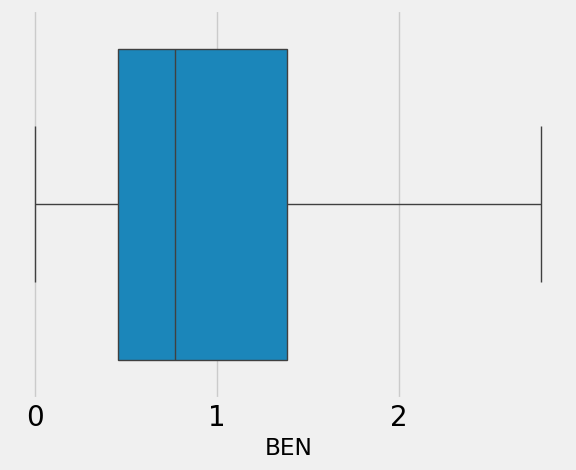

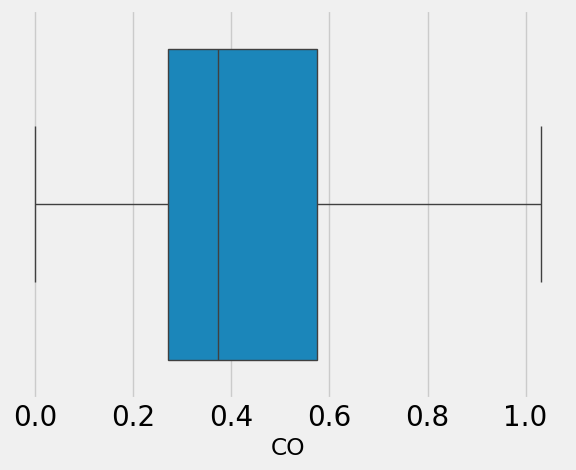

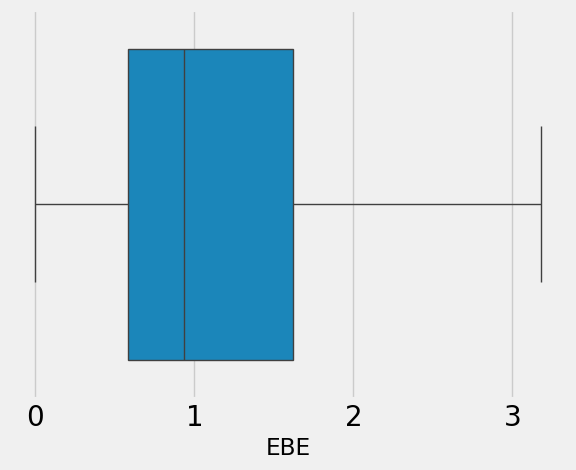

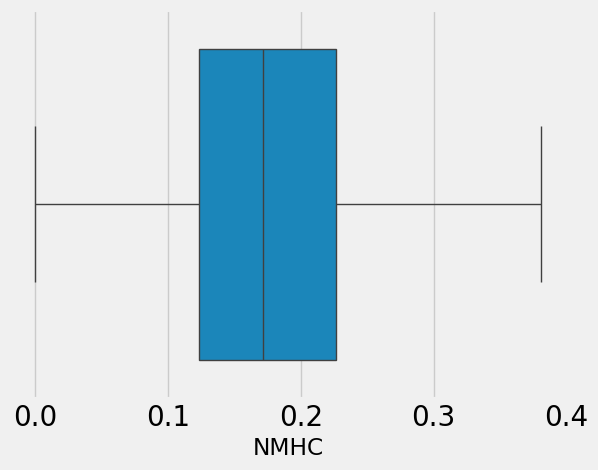

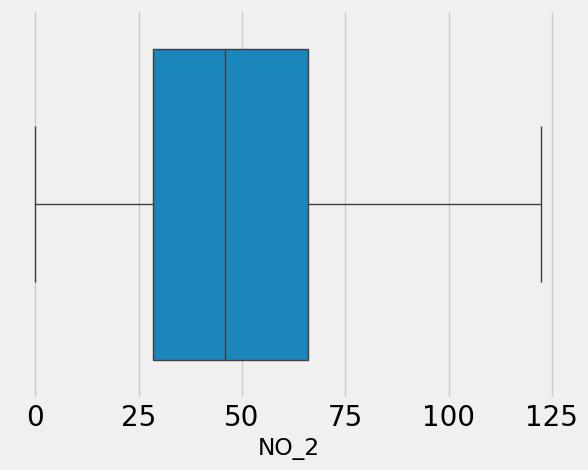

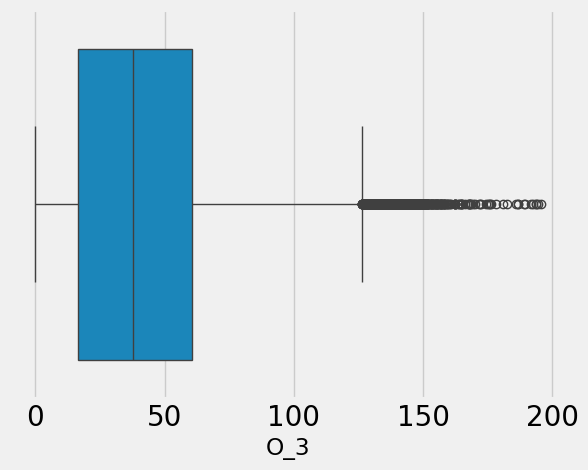

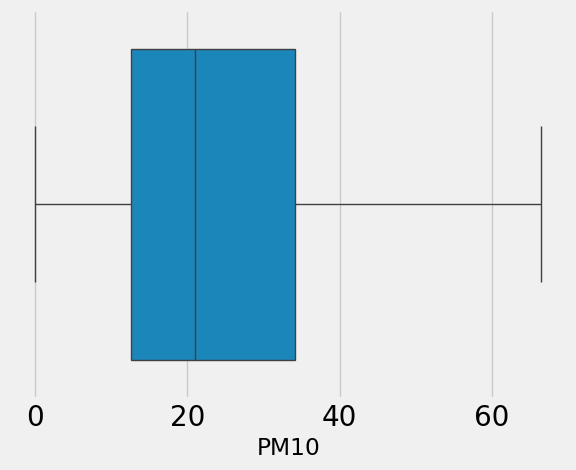

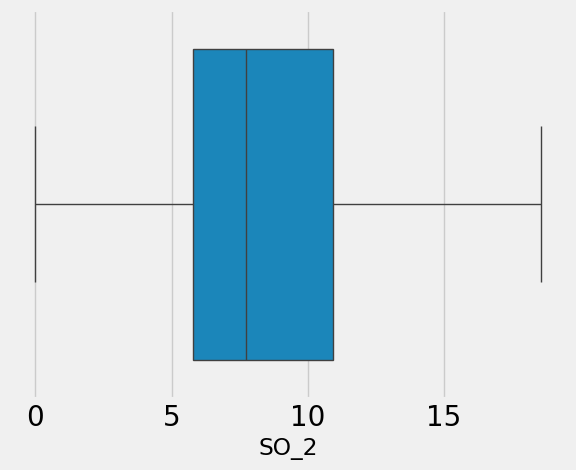

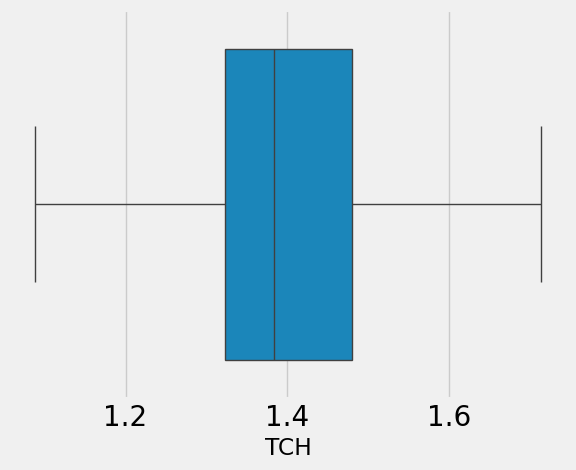

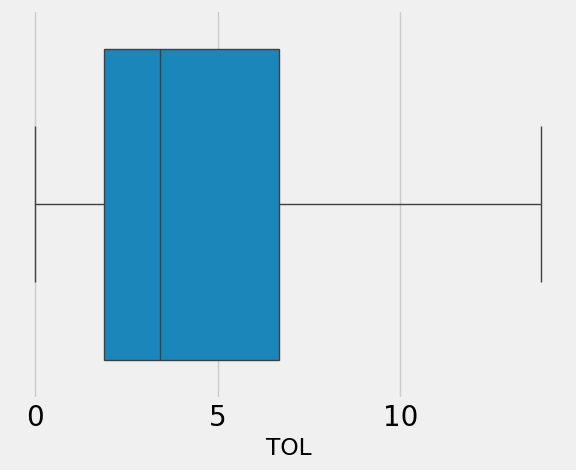

In [29]:
for i in ['BEN', 'CO', 'EBE', 'NMHC', 'NO_2', 'O_3', 'PM10', 'SO_2', 'TCH',
       'TOL']:
  sns.boxplot(data=df,x=i)
  plt.show()

####Data Before Cleaning Vs Data After Cleaning

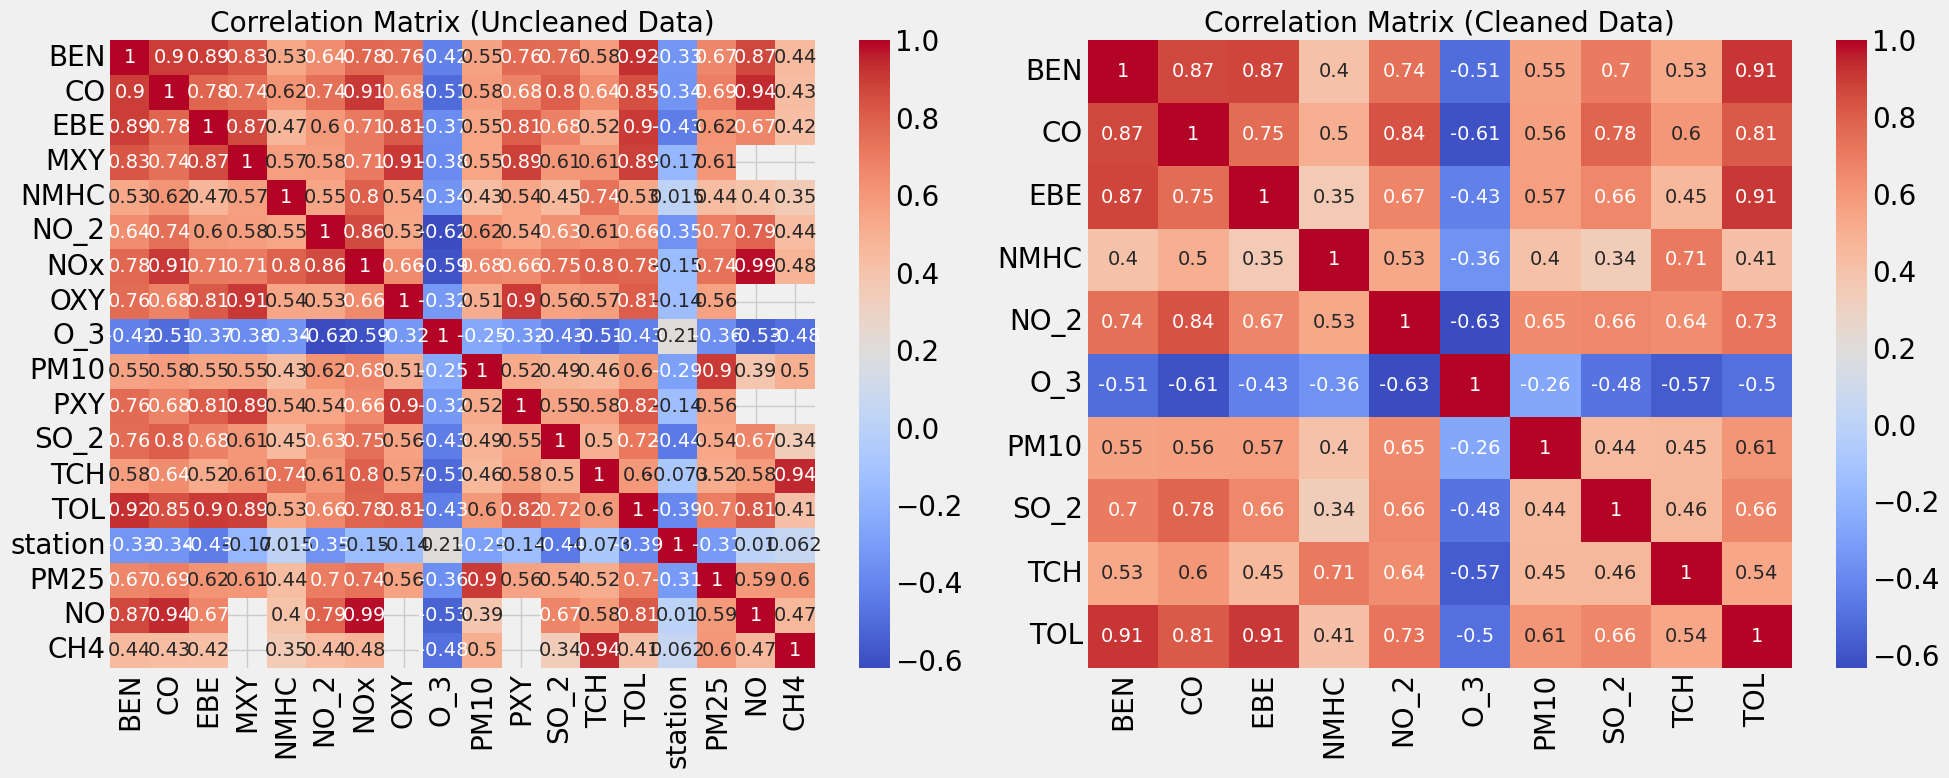

In [30]:

# Calculate correlation for uncleaned data
corr_uncleaned = df_init.select_dtypes(include='number').corr()

# Calculate correlation for cleaned data
corr_cleaned = df.select_dtypes(include='number').corr()

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap for uncleaned data
sns.heatmap(corr_uncleaned, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix (Uncleaned Data)')

# Heatmap for cleaned data
sns.heatmap(corr_cleaned, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix (Cleaned Data)')

plt.tight_layout()
plt.show()


Features to REMOVE (Weak negative correlation): ['PM10']
Features to KEEP (Strong negative correlation): ['BEN', 'CO', 'EBE', 'NMHC', 'NO_2', 'SO_2', 'TCH', 'TOL']


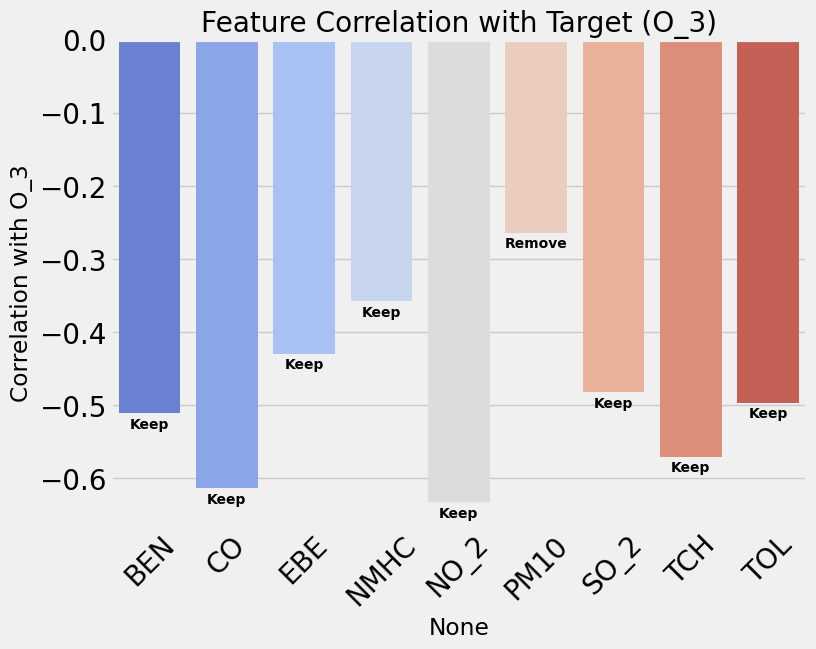

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define correlation threshold (adjustable)
correlation_threshold = 0.3  # Keep features with abs(correlation) >= 0.3

# Get correlations of all features with 'O_3', excluding itself
corr_with_target = corr_cleaned["O_3"].drop("O_3")

# Select features with strong negative correlation (abs value high)
to_remove = corr_with_target[abs(corr_with_target) < correlation_threshold].index.tolist()
to_keep = corr_with_target[abs(corr_with_target) >= correlation_threshold].index.tolist()

# Print results
print("\nFeatures to REMOVE (Weak negative correlation):", to_remove)
print("Features to KEEP (Strong negative correlation):", to_keep)

# Plot bar chart
plt.figure(figsize=(8,6))
sns.barplot(
    x=corr_with_target.index,
    y=corr_with_target.values,
    palette="coolwarm"
)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Reference line
plt.ylabel("Correlation with O_3")
plt.xticks(rotation=45)
plt.title("Feature Correlation with Target (O_3)")

# Annotate features to be removed
for i, v in enumerate(corr_with_target.values):
    plt.text(i, v + 0.02 if v > 0 else v - 0.02,  
             "Remove" if abs(v) < correlation_threshold else "Keep", 
             color="black", ha="center", fontsize=10, fontweight="bold")

plt.show()


### Stationary Check

In [59]:
df_new=df
Y = df_new.drop(['O_3','BEN','EBE','PM10','TCH','TOL','NMHC','NO_2','SO_2'], axis=1)
z= df_new['O_3']
df_new=pd.concat([Y,z], axis=0)
print(z)

# df_new.head()

date
2001-01-01 01:00:00     7.829200
2001-01-01 02:00:00     7.074400
2001-01-01 03:00:00     6.833200
2001-01-01 04:00:00     7.185600
2001-01-01 05:00:00     7.959200
                         ...    
2018-04-30 20:00:00    81.428571
2018-04-30 21:00:00    72.571429
2018-04-30 22:00:00    67.571429
2018-04-30 23:00:00    53.428571
2018-05-01 00:00:00    56.357143
Name: O_3, Length: 151896, dtype: float64


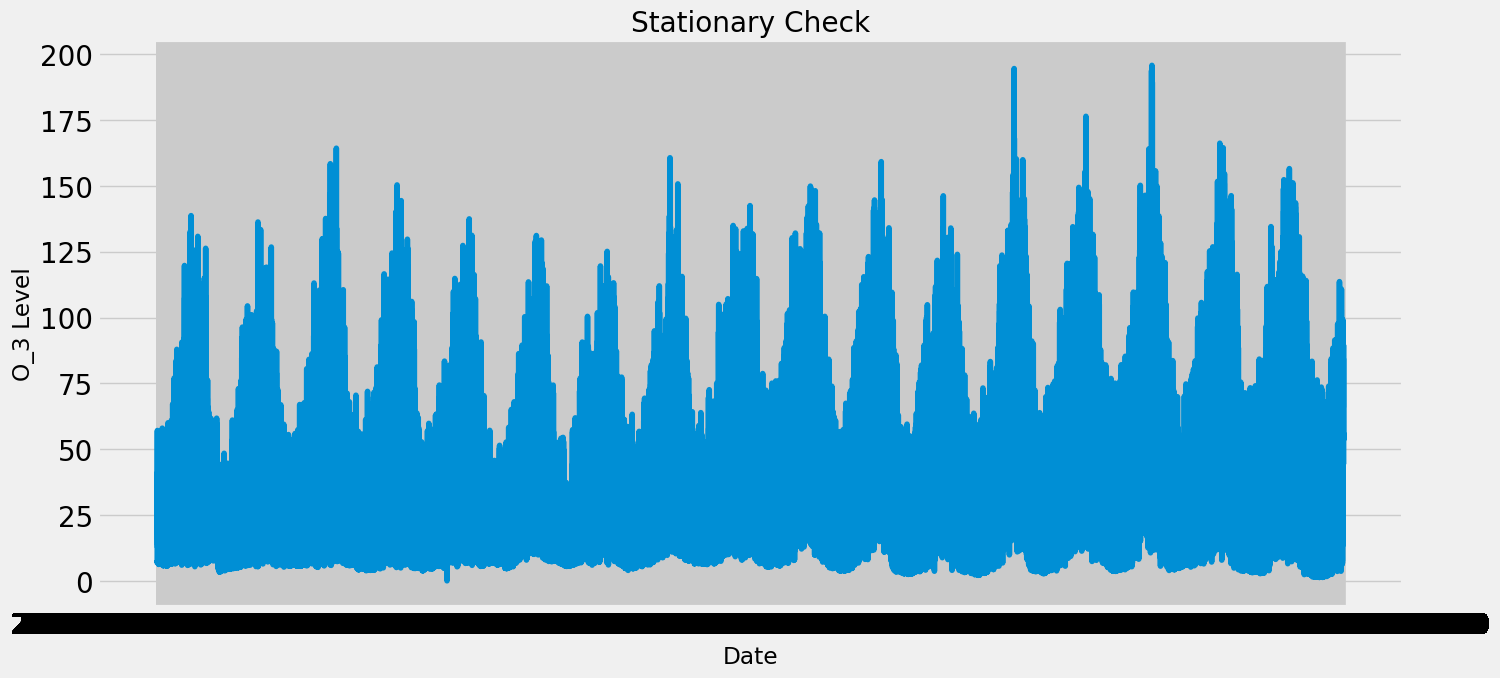

In [60]:
plt.figure(figsize=(15,7))
plt.title("Stationary Check")
plt.xlabel('Date')
plt.ylabel('O_3 Level')
plt.plot(z)
plt.show()

##Ad fuler test

In [67]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(z.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.807250
p-value: 0.000000


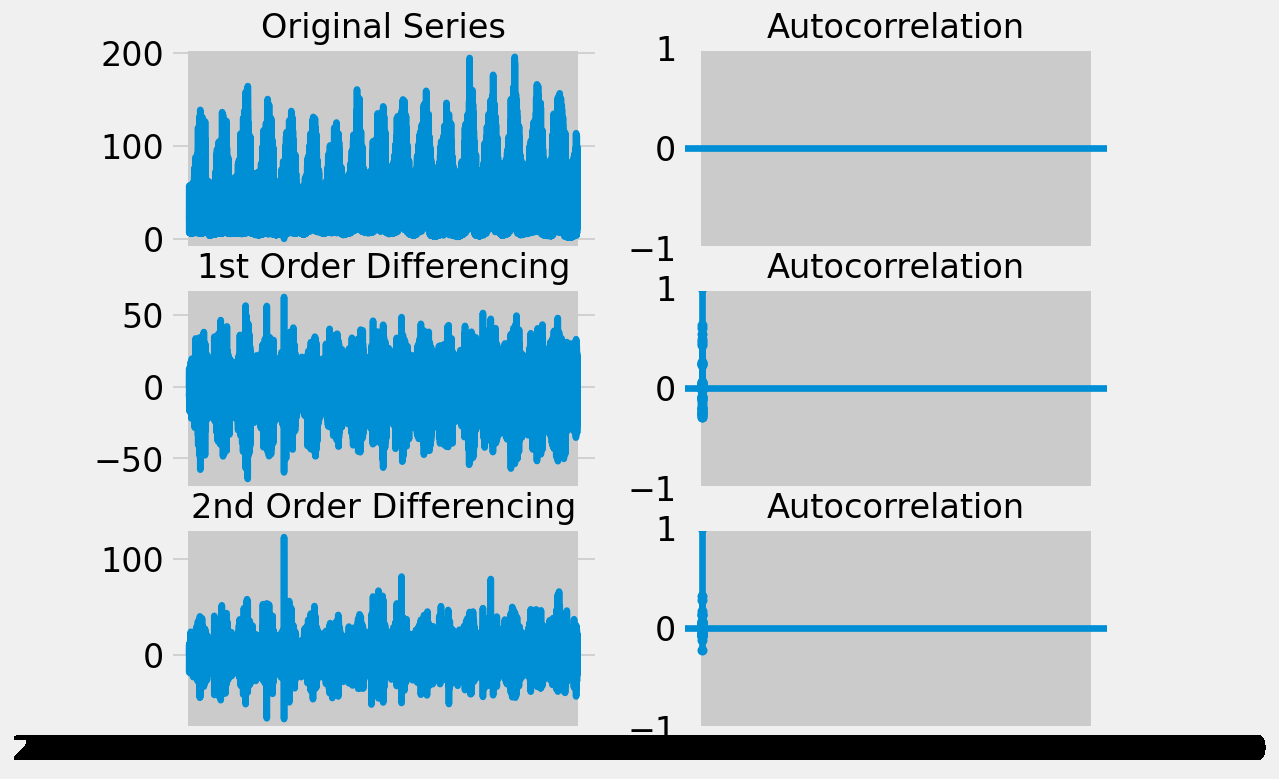

In [69]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (9, 7), 'figure.dpi': 120})

# Assuming z is a Pandas Series
fig, axes = plt.subplots(3, 2, sharex=True)

axes[0, 0].plot(z); 
axes[0, 0].set_title('Original Series')
plot_acf(z, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(z.diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(z.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(z.diff().diff()); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(z.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(z.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(z.diff().dropna(), ax=axes[1])

plt.show()

###Scalling the Data

In [31]:
scaler=MinMaxScaler()
df_scaled=scaler.fit_transform(df)
df_scaled=pd.DataFrame(df_scaled,columns=df.columns)
print('Data Before Scalling:')
print(df.head())
print('Data After Scaling:')
print(df_scaled.head())

Data Before Scalling:
                        BEN      CO       EBE      NMHC       NO_2     O_3  \
date                                                                         
2001-01-01 01:00:00  2.7825  1.0325  2.560000  0.239000  55.287601  7.8292   
2001-01-01 02:00:00  2.7825  1.0325  3.183333  0.381212  55.848400  7.0744   
2001-01-01 03:00:00  2.7825  1.0325  3.183333  0.381212  55.720800  6.8332   
2001-01-01 04:00:00  2.7825  1.0325  3.183333  0.365000  56.596800  7.1856   
2001-01-01 05:00:00  2.7825  1.0325  3.183333  0.260000  53.827600  7.9592   

                          PM10       SO_2    TCH        TOL  
date                                                         
2001-01-01 01:00:00  30.660417  18.581308  1.575  10.584444  
2001-01-01 02:00:00  41.035909  18.581308  1.715  13.871696  
2001-01-01 03:00:00  56.345218  18.581308  1.715  13.871696  
2001-01-01 04:00:00  47.972083  18.581308  1.715  13.871696  
2001-01-01 05:00:00  36.637083  18.581308  1.715  13.871696

###Splitting Datset

In [13]:
# x=df_scaled.drop('O_3',axis=1)
# y=df_scaled['O_3']
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
# df_scaled.tail()

df_scaled_cudf = cudf.DataFrame.from_pandas(df_scaled)

# Drop the 'O_3' column from x (predictors) and assign it to y (target)
x = df_scaled_cudf.drop('O_3', axis=1)
y = df_scaled_cudf['O_3']

# Split the data into training and test sets using cuml's train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Check the tail of the cuDF DataFrame
print(df_scaled_cudf.tail())

               CO      NO_2       O_3      PM10      SO_2
2991727  0.554787  1.000000  0.008475  0.525141  0.623068
2991728  0.487805  0.640823  0.004237  0.592217  0.623068
2991729  0.554787  0.338016  0.008475  0.525141  0.623068
2991730  0.554787  0.725327  0.008475  0.525141  0.623068
2991731  0.554787  0.676033  0.012712  0.439932  0.623068


#Model Train

### 1. Linear Regression

In [16]:

model1=LinearRegression()
model1.fit(x_train,y_train)

LinearRegression()

In [17]:
y_predict=model1.predict(x_test)

Mean Absolute Error (MAE): 0.07701293111920618
Explained Variance Score: 0.40139815623400665
Mean of Residuals (in percentage): 0.007396127963061681%


<Axes: ylabel='Density'>

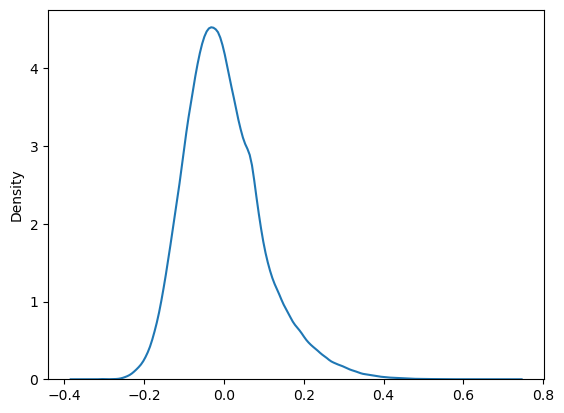

In [32]:
import cudf
import cupy as cp
import seaborn as sns
from cuml.metrics import mean_absolute_error

# Assuming y_test and y_predict are cuDF Series (GPU-based dataframes)
y_test_gpu = y_test.to_cupy()  # Convert to cuPy array for GPU-based operations
y_predict_gpu1 = y_predict.to_cupy()

# Calculate MAE using cuML (GPU-based)
l_mae1 = mean_absolute_error(y_test_gpu, y_predict_gpu1)

# Manually calculate Explained Variance Score
residuals1 = y_test_gpu - y_predict_gpu1
explained_variance1 = 1 - cp.var(residuals1) / cp.var(y_test_gpu)

# Print the results
print(f"Mean Absolute Error (MAE): {l_mae1}")
print(f"Explained Variance Score: {explained_variance1}")

# Residual Calculation
residue_gpu1 = residuals1
print(f"Mean of Residuals (in percentage): {residue_gpu1.mean() * 100}%")

# Plotting the residuals (converting back to CPU for seaborn)
sns.kdeplot(x=residue_gpu1.get())  # .get() moves the data to CPU for plotting


### 2. Random Forest Regressor

In [25]:
model2=RandomForestRegressor()
model2.fit(x_train,y_train)

/home/abir_hossain/anaconda3/envs/P2/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RandomForestRegressor()

In [26]:
y_predict2=model2.predict(x_test)

Mean Absolute Error (MAE): 0.06664095789805333
Explained Variance Score: 0.5075479779398462
Mean of Residuals (in percentage): -0.01958416939135167%


<Axes: ylabel='Density'>

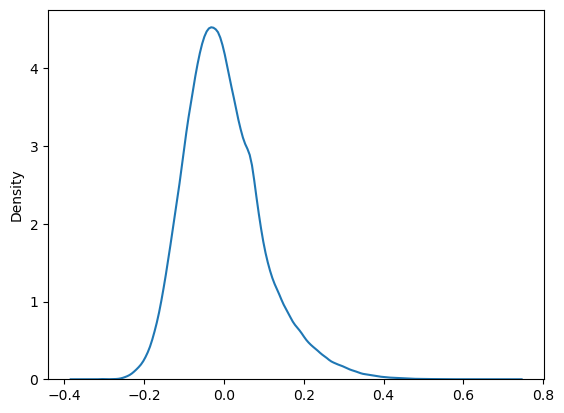

In [33]:

# Assuming y_test and y_predict are cuDF Series (GPU-based dataframes)
y_predict_gpu2 = y_predict2.to_cupy()

# Calculate MAE using cuML (GPU-based)
l_mae2 = mean_absolute_error(y_test_gpu, y_predict_gpu2)

# Manually calculate Explained Variance Score
residuals2 = y_test_gpu - y_predict_gpu2
explained_variance2 = 1 - cp.var(residuals2) / cp.var(y_test_gpu)

# Print the results
print(f"Mean Absolute Error (MAE): {l_mae2}")
print(f"Explained Variance Score: {explained_variance2}")

# Residual Calculation
residue_gpu2 = residuals2
print(f"Mean of Residuals (in percentage): {residue_gpu2.mean() * 100}%")

# Plotting the residuals (converting back to CPU for seaborn)
sns.kdeplot(x=residue_gpu.get())  # .get() moves the data to CPU for plotting


###5. Ridge Regressor

In [39]:
model5=Ridge(alpha=0.1)
model5.fit(x_train,y_train)


Ridge()

In [40]:
y_predict5=model5.predict(x_test)

Mean Absolute Error (MAE): 0.07701292944155229
Explained Variance Score: 0.4013981560354011
Mean of Residuals (in percentage): 0.0073961402784221844%


<Axes: ylabel='Density'>

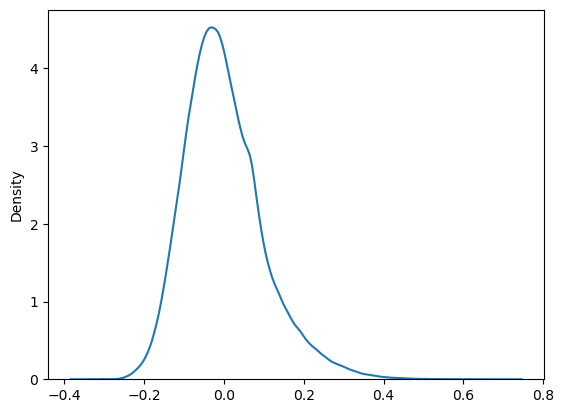

In [41]:


# Assuming y_test and y_predict are cuDF Series (GPU-based dataframes)
y_predict_gpu5 = y_predict5.to_cupy()

# Calculate MAE using cuML (GPU-based)
l_mae5 = mean_absolute_error(y_test_gpu, y_predict_gpu5)

# Manually calculate Explained Variance Score
residuals5 = y_test_gpu - y_predict_gpu5
explained_variance5 = 1 - cp.var(residuals5) / cp.var(y_test_gpu)

# Print the results
print(f"Mean Absolute Error (MAE): {l_mae5}")
print(f"Explained Variance Score: {explained_variance5}")

# Residual Calculation
residue_gpu5 = residuals5
print(f"Mean of Residuals (in percentage): {residue_gpu5.mean() * 100}%")

# Plotting the residuals (converting back to CPU for seaborn)
sns.kdeplot(x=residue_gpu5.get())  # .get() moves the data to CPU for plotting


#Performance Comparison

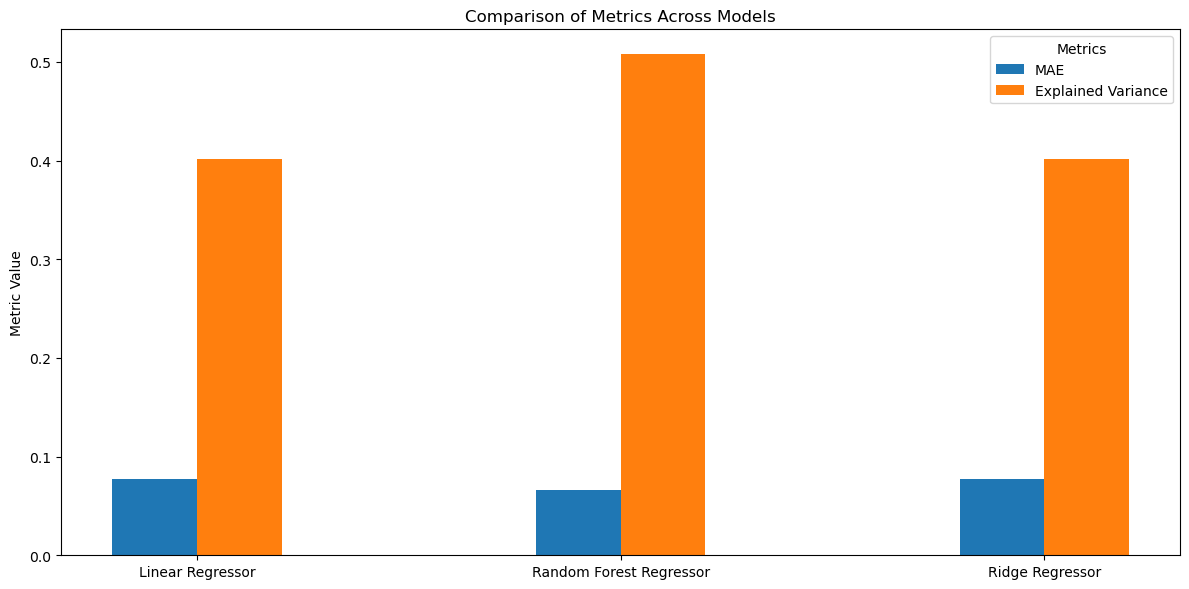

In [42]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

# Example values for metrics (ensure that these are CuPy arrays or GPU-based)Mean Absolute Error (MAE):


l_mae1 = cp.array([0.07701293111920618])  # Replace with actual GPU results
l_mae2 = cp.array([0.06664095789805333])
l_mae5 = cp.array([0.07701292944155229])

explained_variance1 = cp.array([0.40139815623400665])
explained_variance2 = cp.array([0.5075479779398462])
explained_variance5 = cp.array([0.4013981560354011])

# Convert CuPy arrays to NumPy arrays for compatibility with plotting
metric_values = np.array([
    [l_mae1.get()[0], l_mae2.get()[0], l_mae5.get()[0]],  # Access scalar values
    [explained_variance1.get()[0], explained_variance2.get()[0], explained_variance5.get()[0]],  # Access scalar values
])

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
model_names = ["Linear Regressor", "Random Forest Regressor", 'Ridge Regressor']
metrics = ["MAE", "Explained Variance"]
x = np.arange(len(model_names))

bar_width = 0.2
for i, metric in enumerate(metrics):
    ax.bar(x + i * bar_width, metric_values[i], width=bar_width, label=metric)

ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(model_names)
ax.set_ylabel("Metric Value")
ax.set_title("Comparison of Metrics Across Models")
ax.legend(title="Metrics")
plt.tight_layout()
plt.show()
